# **Classical ML Methods**

In [1]:
import mlflow
from pathlib import Path

In [2]:
# Set tracking URI
MODEL_REGISTRY = Path("experiments")
Path(MODEL_REGISTRY).mkdir(exist_ok=True) # create experiments dir
mlflow.set_tracking_uri("file://" + str(MODEL_REGISTRY.absolute()))

In [3]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "file://" + str(MODEL_REGISTRY.absolute())

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

client.list_experiments()

[<Experiment: artifact_location='file:///mnt/c/Users/avoronk/skills/notebooks/experiments/0', experiment_id='0', lifecycle_stage='active', name='baselines', tags={}>,
 <Experiment: artifact_location='file:///mnt/c/Users/avoronk/skills/notebooks/experiments/1', experiment_id='1', lifecycle_stage='active', name='optimization', tags={}>,
 <Experiment: artifact_location='file:///mnt/c/Users/avoronk/skills/notebooks/experiments/2', experiment_id='2', lifecycle_stage='active', name='models_comparison', tags={}>,
 <Experiment: artifact_location='file:///mnt/c/Users/avoronk/skills/notebooks/experiments/3', experiment_id='3', lifecycle_stage='active', name='voting_clf', tags={}>]

In [8]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids='3',
    filter_string="metrics.accuracy > .92",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.accuracy DESC"]
)

In [9]:
print(runs)

[<Run: data=<RunData: metrics={'accuracy': 0.9206330160081004}, params={'model': 'VotingClassifier'}, tags={'feature': 'text_tag',
 'mlflow.log-model.history': '[{"run_id": "27ea20fed8544266a5d9f0ce7b3cca2d", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2022-11-20 19:07:32.127261", "flavors": '
                             '{"python_function": {"model_path": "model.pkl", '
                             '"loader_module": "mlflow.sklearn", '
                             '"python_version": "3.8.10", "env": '
                             '"conda.yaml"}, "sklearn": {"pickled_model": '
                             '"model.pkl", "sklearn_version": "0.24.2", '
                             '"serialization_format": "cloudpickle"}}}]',
 'mlflow.source.name': '/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'anton'}>, info=<RunInfo: artifact_uri='file

In [14]:
from argparse import Namespace

In [15]:
params = Namespace(**run.data.params)

In [23]:
exec('mod = ' + params.model)
print(mod)

<class 'sklearn.ensemble._voting.VotingClassifier'>


In [5]:
for run in runs:
    print(f"run id: {run.info.run_id}, accuracy: {run.data.metrics['accuracy']:.4f}, model: {run.data.params['model']}")

In [19]:
for run in runs:
    exec('mod = ' + params.model)
mod

sklearn.ensemble._voting.VotingClassifier

In [15]:
mod2 = LinearSVC()
print(mod2)

LinearSVC()


In [7]:
for run in runs:
    print(f"run id: {run.info.run_id}, accuracy: {run.data.metrics['accuracy']:.4f}, model: {run.data.params}")

run id: 9f85f2f2feb74c4ca940205d6ed0cc01, accuracy: 0.9216, model: {'C': '0.19723509689793517', 'model': 'LinearSVC'}


In [25]:
client = MlflowClient()

# retrieve the top_n model runs and log the models to MLflow
experiment = client.get_experiment_by_name('models_comparison')
runs = client.search_runs(
    experiment_ids=experiment.experiment_id,
    filter_string="metrics.accuracy > .8",
    run_view_type=ViewType.ACTIVE_ONLY,
    order_by=["metrics.accuracy DESC"]
)[0]

print(runs.data.params)

# select the model with the lowest test RMSE
# experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
# best_run = client.search_runs( ...  )[0]

# register the best model
# mlflow.register_model( ... )

{'C': '0.19723509689793517', 'model': 'LinearSVC'}


In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/full_dataset.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

# Feature engineering
df["text_tag"] = df.text + ' ' + df.tag

df.head(5)

,tag,text,isSameBlock,job_id,provider,jobTitle,company,location,experience,target,text_tag
0,text inside SECTION,"The Supercharging network, the world’s fastest...",False,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,1,"The Supercharging network, the world’s fastest..."
1,text inside DIV,The Role,True,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,0,The Role text inside DIV
2,text inside STRONG,Responsibilities,False,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,0,Responsibilities text inside STRONG
3,LI,"Develop database, KPIs, and dashboards to faci...",False,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,1,"Develop database, KPIs, and dashboards to faci..."
4,LI,"Ensure consistency, reliability and quality of...",False,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,1,"Ensure consistency, reliability and quality of..."


In [4]:
# Set experiment
mlflow.set_experiment("models_comparison")

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [6]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [41]:
def objective(params):
    with mlflow.start_run():
        vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
        
        classifier_type = params['type']
        del params['type']
        
        for feature in ({"title":"text"}, {"title":"text_tag"}):
            mlflow.set_tag("feature", feature["title"])
            mlflow.log_params(params)

            # Tf-idf
            X_train = vectorizer.fit_transform(df[feature["title"]].to_numpy())
            y_train = df.target

            if classifier_type == 'svm':
                clf = LinearSVC(**params)
            elif classifier_type == 'rf':
                clf = RandomForestClassifier(**params)
            elif classifier_type == 'logreg':
                clf = LogisticRegression(**params)
            elif classifier_type == 'mnb':
                clf = MultinomialNB(**params)
            else:
                return 0
            accuracy = cross_val_score(clf, X_train, y_train).mean()
            mlflow.log_metric("accuracy", accuracy)
        
            mlflow.log_param('model', type(clf).__name__)
            mlflow.sklearn.log_model(clf, 'model')
    
            # Because fmin() tries to minimize the objective, this function must return the negative accuracy. 
        return {'loss': accuracy, 'status': STATUS_OK}        

In [42]:
search_space = hp.choice('classifier_type', [
    {
        'type': 'svm',
        'C': hp.lognormal('SVM_C', 0, 1.0),
    },
    {
        'type': 'rf',
        'max_depth': hp.quniform('max_depth', 2, 5, 1),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
    {
        'type': 'logreg',
        'C': hp.lognormal('LR_C', 0, 1.0),
        'solver': hp.choice('solver', ['liblinear', 'lbfgs']),
    },
    {
        'type': 'mnb',
        'alpha': hp.lognormal('alpha', 0, 1.0)
    },
])

In [43]:
best_result = fmin(
        fn=objective, 
        space=search_space,
        algo=tpe.suggest,
        max_evals=50,
        trials=Trials()
)

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 44/50 [06:12<00:46,  7.80s/trial, best loss: 0.605918554219868]

/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [07:06<00:00,  8.53s/trial, best loss: 0.605918554219868]


In [26]:
# Set experiment
mlflow.set_experiment("voting_clf")

In [38]:
import pickle

In [39]:
with mlflow.start_run():
        
    mlflow.set_tag("feature", "text_tag")
    
    vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
    
    X_train = vectorizer.fit_transform(df.text_tag.to_numpy())
    y_train = df.target
    
    with open('./experiments/2/c21751c9d80c41a3b71240febefd0892/artifacts/model/model.pkl', 'rb') as f:
        lr_clf = pickle.load(f)

    with open('./experiments/2/9f85f2f2feb74c4ca940205d6ed0cc01/artifacts/model/model.pkl', 'rb') as f:
        svm_clf = pickle.load(f)
        
    clf = VotingClassifier(
        estimators = [
                  ('lr',lr_clf),
                  ('svm',svm_clf), 
                  ],
        voting='hard')
    

    accuracy = cross_val_score(clf, X_train, y_train).mean()
    mlflow.log_metric("accuracy", accuracy)
        
    mlflow.log_param('model', type(clf).__name__)
    mlflow.sklearn.log_model(clf, 'model')

In [87]:
def objective(args, trial):
    """Objective function for optimization trials."""
    # Parameters to tune
    args.analyzer = trial.suggest_categorical("analyzer", ["word", "char", "char_wb"])
    args.ngram_max_range = trial.suggest_int("ngram_max_range", 3, 10)
    args.loss = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
    args.tol = trial.suggest_loguniform("tol", 1e-2, 1e0)
    args.C = trial.suggest_uniform("C", 0.1, 10)
    args.solver = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear", "sag", "saga"])

    # Train & evaluate
    artifacts = train(args=args, df=df, trial=trial)

    # Set additional attributes
    performance = artifacts["performance"]
    print(json.dumps(performance, indent=2))
    trial.set_user_attr("precision", performance["precision"])
    trial.set_user_attr("recall", performance["recall"])
    trial.set_user_attr("f1", performance["f1"])

    return performance["f1"]

In [13]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.921563
LogisticRegression        0.920883
MultinomialNB             0.908430
RandomForestClassifier    0.639518
Name: accuracy, dtype: float64

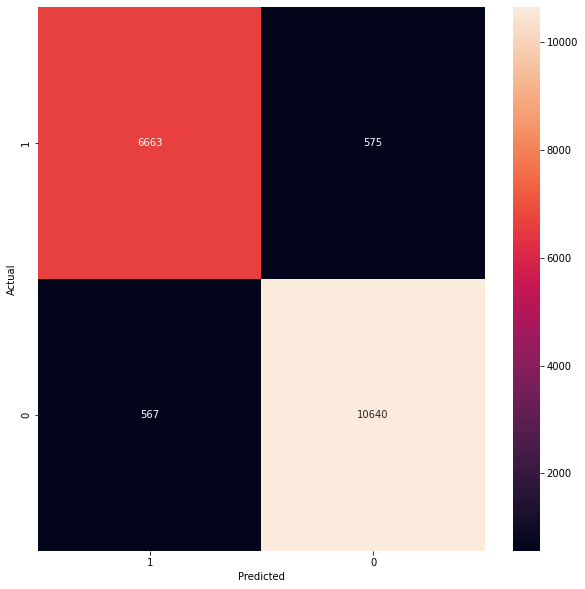

In [94]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(text, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df.target.unique(), yticklabels=df.target.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

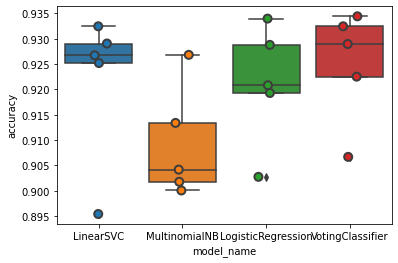

In [112]:
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(random_state=0)
mnb_clf = MultinomialNB()
svm_clf = LinearSVC()
voting_clf = VotingClassifier(
    estimators = [
                  ('lr',log_clf),
                  ('mnb',mnb_clf),
                  ('svm',svm_clf), 
                  ],
    voting='hard')

from sklearn.ensemble import VotingClassifier

models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    VotingClassifier(
    estimators = [
                  ('lr',log_clf),
                  ('mnb',mnb_clf),
                  ('svm',svm_clf), 
                  ],
    voting='hard'),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, text, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [4]:
# Set experiment
mlflow.set_experiment("voting_clf")

In [113]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC             0.921778
LogisticRegression    0.921134
MultinomialNB         0.909253
VotingClassifier      0.925016
Name: accuracy, dtype: float64

In [ ]:
accuracies = cross_val_score(model_transf, features, y=None, scoring='accuracy', cv=CV)

TypeError: ignored

In [116]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, mnb_clf, svm_clf, voting_clf):
    clf.fit(text, labels)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.9486039577121171
MultinomialNB 0.9312008674437517
LinearSVC 0.974573055028463


/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier 0.9568988885876931


/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


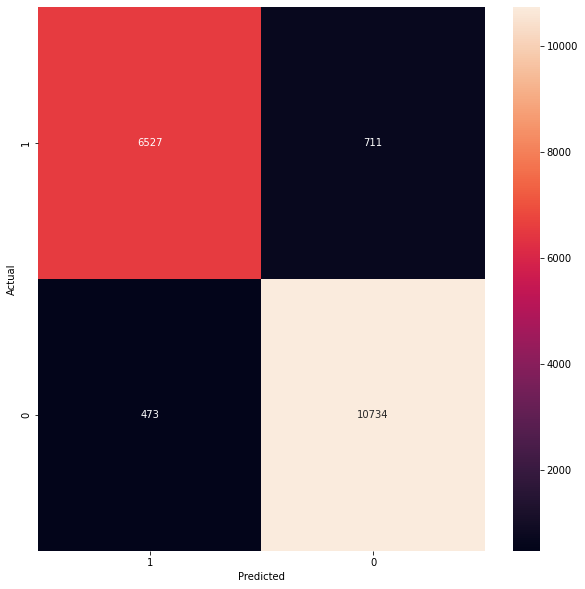

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split

log_clf = LogisticRegression(random_state=0)
mnb_clf = MultinomialNB()
svm_clf = LinearSVC()



model = VotingClassifier(estimators = [('lr',log_clf), ('mnb',mnb_clf), ('svm',svm_clf)], voting='hard')

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(text, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df.target.unique(), yticklabels=df.target.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

wrong_predictions: A list of InputFeature of each incorrect prediction. The text may be obtained from the InputFeature.text_a attribute. (The InputFeature class can be found in the utils.py file in the repo)

# **Full dataset**

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import  WordNetLemmatizer
import re
lem = WordNetLemmatizer()def filter_command(phrase):
 tokens=[]
 tok=word_tokenize(phrase)
 for t in tok:
  tokens.append(tok.lower())
 tags = nltk.pos_tag(tokens)work=[]
 work_f=[]
 subject=[]
 number=[]
 adj=[]
 query=[]
 name=0
 for tup in tags:
  if "VB" in tup[1]:
   work.append(tup[0])
  if "CD" in tup[1]:
   number.append(tup[0])
  if "JJ" in tup[1]:
   adj.append(tup[0])
  if "NN" in tup[1]:
   subject.append(tup[0])
  if "W" in tup[1] and "that" not in tup[0]:
   query.append(tup[0]) 
 for w in work:
  work_f.append(lem.lemmatize(w.lower()))
 if query:
  if "you" in tokens or "your" in tokens:
   task=0
  elif 'weather' not in tokens or 'news' not in tokens or 'headlines' not in tokens: 
   task=1
 elif 'play' in work_f or 'song' in subject or 'play' in subject:
  task=2
 elif 'book' in work_f or 'book' in tokens[0]:
  task=3
 elif 'weather' in subject:
  task=4
 elif 'news' in subject or 'headlines' in subject:
  task=5
 else:
  
  if '?' in tokens and 'you' not in tokens and 'your' not in tokens:
   task=1
  else:
   task=0 
 
 return task,work_f,subject,number,adj,query

In [ ]:
dataset = pd.read_csv('full_dataset.csv')

In [ ]:
dataset.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
dataset.head()

,tag,text,isSameBlock,job_id,provider,jobTitle,company,location,experience,target
0,text inside SECTION,"The Supercharging network, the world’s fastest...",False,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,1
1,text inside DIV,The Role,True,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,0
2,text inside STRONG,Responsibilities,False,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,0
3,LI,"Develop database, KPIs, and dashboards to faci...",False,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,1
4,LI,"Ensure consistency, reliability and quality of...",False,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,1


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# tfidf_text = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))
# tfidf_tag = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))

# text = tfidf_text.fit_transform(dataset.text)
# tag = tfidf_tag.fit_transform(dataset.tag)

tfidf_text = load('tfidf_text.joblib')
tfidf_tag = load('tfidf_tag.joblib')

text = tfidf_text.transform(dataset.text)
tag = tfidf_tag.transform(dataset.tag)

X = hstack([text, tag])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


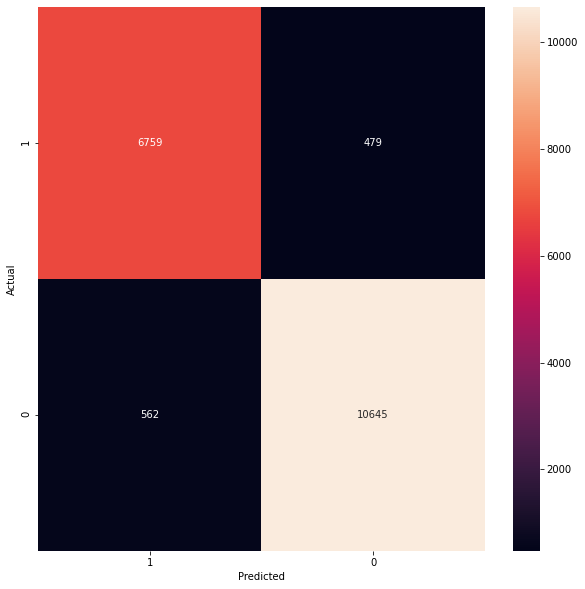

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

log_clf = LogisticRegression(random_state=0, class_weight='balanced')
mnb_clf = MultinomialNB()
svm_clf = LinearSVC(class_weight='balanced')



model = VotingClassifier(estimators = [
                                       ('lr',log_clf), 
                                       ('mnb',mnb_clf), 
                                       ('svm',svm_clf)
                                       ], 
                         voting='hard')

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, dataset.target, dataset.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=dataset.target.unique(), yticklabels=dataset.target.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
accuracy_score(y_test, y_pred)

0.9435619409053945

In [ ]:
hr_target = clf.predict(X)

In [ ]:
for i in range(len(hr['jobs'])):
  hr['jobs'][i]['target'] = hr_target[i]

1479847


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



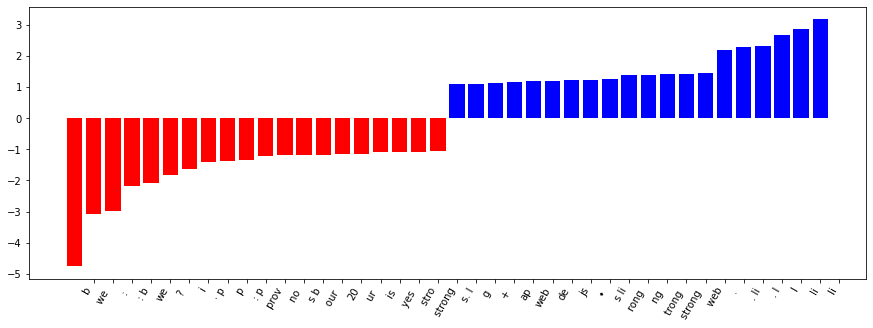

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
cv = TfidfVectorizer(analyzer=args.analyzer, ngram_range=(2,args.ngram_max_range))
cv.fit(df['text'])
print (len(cv.vocabulary_))
print (cv.get_feature_names())
X_train = cv.transform(df['text'])

svm = LinearSVC()
svm.fit(X_train, df['target'])
plot_coefficients(svm, cv.get_feature_names())

In [ ]:
def train(args, df, trial=None):
    """Train model on data."""

    # Setup
    set_seeds()
    
    X_train, X_val, X_test, y_train, y_val, y_test = \
        get_data_splits(X=df.text.to_numpy(), y=df.target)

    # Tf-idf
    vectorizer = TfidfVectorizer(analyzer=args.analyzer, ngram_range=(2,args.ngram_max_range))  # char n-grams
    # vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
    X_train = vectorizer.fit_transform(X_train)
    X_val = vectorizer.transform(X_val)
    X_test = vectorizer.transform(X_test)

    # Oversample
    # oversample = RandomOverSampler(sampling_strategy="all")
    # X_over, y_over = oversample.fit_resample(X_train, y_train)

    # Model
    log_clf = LogisticRegression(random_state=0, tol=args.tol, C=args.C, solver=args.solver)
    # mnb_clf = MultinomialNB()
    svm_clf = LinearSVC(loss=args.loss, tol=args.tol, C=args.C)
    model = VotingClassifier(
        estimators = [
                  ('lr',log_clf),
                  # ('mnb',mnb_clf),
                  ('svm',svm_clf), 
                  ],
        voting='hard')

    # Training
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(report)

    # Pruning (for optimization in next section)
    if trial:
        # trial.report(report, 1)
        if trial.should_prune():
            raise optuna.TrialPruned()


    # Evaluation
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print (json.dumps(performance, indent=2))

    return {
        "args": args,
        "vectorizer": vectorizer,
        "model": model,
        "performance": performance
    }

In [5]:
# Convert to parquet
df.to_parquet(
    "../data/full_dataset.parquet",
    compression=None,
)

In [11]:
par = pd.read_parquet("../data/full_dataset.parquet")
par.head()

,Unnamed: 0,tag,text,isSameBlock,job_id,provider,jobTitle,company,location,experience,target,created_on
0,0,text inside SECTION,"The Supercharging network, the world’s fastest...",False,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,1,2022-08-11 12:16:02.814296
1,1,text inside DIV,The Role,True,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,0,2022-08-11 12:16:02.814296
2,2,text inside STRONG,Responsibilities,False,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,0,2022-08-11 12:16:02.814296
3,3,LI,"Develop database, KPIs, and dashboards to faci...",False,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,1,2022-08-11 12:16:02.814296
4,4,LI,"Ensure consistency, reliability and quality of...",False,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,1,2022-08-11 12:16:02.814296


In [7]:
par.columns

Index(['Unnamed: 0', 'tag', 'text', 'isSameBlock', 'job_id', 'provider',
       'jobTitle', 'company', 'location', 'experience', 'target'],
      dtype='object')

In [8]:
import datetime
 
current_time = datetime.datetime.now()

df["created_on"] = current_time

In [12]:
df.rename(columns={"Unnamed: 0": "id"}, inplace=True)

In [13]:
df.head()

,id,tag,text,isSameBlock,job_id,provider,jobTitle,company,location,experience,target,created_on
0,0,text inside SECTION,"The Supercharging network, the world’s fastest...",False,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,1,2022-08-11 12:16:02.814296
1,1,text inside DIV,The Role,True,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,0,2022-08-11 12:16:02.814296
2,2,text inside STRONG,Responsibilities,False,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,0,2022-08-11 12:16:02.814296
3,3,LI,"Develop database, KPIs, and dashboards to faci...",False,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,1,2022-08-11 12:16:02.814296
4,4,LI,"Ensure consistency, reliability and quality of...",False,business-analyst-at-tesla-1993536476,linkedin,Business Analyst,Tesla,"Palo Alto, CA",2,1,2022-08-11 12:16:02.814296


In [14]:
df.to_parquet(
    "../data/full_dataset.parquet",
    compression=None,
)

In [2]:
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

In [8]:
from sklearn.model_selection import train_test_split
import random

np.random.seed(42)
random.seed(42)

X = df['text_tag'].to_numpy()
y = df.target

# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Split (train)
X_train, X_, y_train, y_ = train_test_split(
    X, y, train_size=train_size, stratify=y)

# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5, stratify=y_)


vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
X_val = vectorizer.transform(X_val)

# Initialize model
model = SGDClassifier(
    loss="log", penalty="l2", alpha=1e-4, max_iter=1,
    learning_rate="constant", eta0=1e-1, power_t=0.1,
    warm_start=True)

# Train model
num_epochs = 100
for epoch in range(num_epochs):
    # Training
    model.fit(X_train, y_train)

    # Evaluation
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_loss = log_loss(y_val, model.predict_proba(X_val))

    if not epoch%10:
        print(
            f"Epoch: {epoch:02d} | "
            f"train_loss: {train_loss:.5f}, "
            f"val_loss: {val_loss:.5f}"
        )

/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574:

Epoch: 00 | train_loss: 0.29808, val_loss: 0.30017


/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574:

Epoch: 10 | train_loss: 0.24930, val_loss: 0.25684


/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574:

Epoch: 20 | train_loss: 0.24940, val_loss: 0.25650


/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574:

Epoch: 30 | train_loss: 0.24920, val_loss: 0.25713


/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574:

Epoch: 40 | train_loss: 0.24940, val_loss: 0.25644


/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574:

Epoch: 50 | train_loss: 0.24920, val_loss: 0.25643


/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574:

Epoch: 60 | train_loss: 0.24899, val_loss: 0.25667


/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574:

Epoch: 70 | train_loss: 0.24926, val_loss: 0.25653


/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574:

Epoch: 80 | train_loss: 0.24911, val_loss: 0.25677


/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574:

Epoch: 90 | train_loss: 0.24915, val_loss: 0.25664


/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574:

In [9]:
accuracy = cross_val_score(model, X_train, y_train).mean()
accuracy

/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/mnt/c/Users/avoronk/skills/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574:

0.8879971252539903

In [ ]:
    # Evaluation
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

    return {"args": args, "model": model, "performance": performance}